In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

%pip install scikit-learn lxml

import pandas as pd
import json
import os
import glob
from lxml import etree


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfu

In [ ]:
import os
import glob
from lxml import etree
import json
import pandas as pd

# File paths
directory = "/content/drive/My Drive/266_NLP/final project/uspto_patents"
output_json = "/content/drive/My Drive/266_NLP/final project/uspto_patents_cpc_metadata.json"
output_csv = "/content/drive/My Drive/266_NLP/final project/uspto_patents_cpc_metadata.csv"

def extract_all_claims(root):
    claims = root.findall(".//claims/claim")
    all_claims = []
    for claim in claims:
        parts = claim.findall(".//claim-text")
        claim_text = " ".join(
            ''.join(p.itertext()).strip() for p in parts if p is not None
        )
        all_claims.append(claim_text)
    return all_claims


def extract_patent_metadata(xml_path):
    try:
        tree = etree.parse(xml_path)
        root = tree.getroot()

        def gettext(xpath):
            el = root.find(xpath)
            return el.text.strip() if el is not None and el.text else None

        def getalltext(xpath):
            els = root.findall(xpath)
            return [el.text.strip() for el in els if el is not None and el.text]

        # Fetch all parts together
        sections = getalltext(".//classification-cpc/section")
        classes = getalltext(".//classification-cpc/class")
        subclasses = getalltext(".//classification-cpc/subclass")
        main_groups = getalltext(".//classification-cpc/main-group")
        subgroups = getalltext(".//classification-cpc/subgroup")

        # Zip CPC levels to produce full identifiers
        cpc_entries = list(zip(sections, classes, subclasses, main_groups, subgroups))

        def safe_join(*parts, sep=""):
            return sep.join(p for p in parts if p)

        metadata = {
            "file": os.path.basename(xml_path),
            "publication_number": gettext(".//publication-reference/document-id/doc-number"),
            "application_number": gettext(".//application-reference/document-id/doc-number"),
            "publication_date": gettext(".//publication-reference/document-id/date"),
            "application_date": gettext(".//application-reference/document-id/date"),
            "invention_title": gettext(".//invention-title"),

            # Construct full identifiers
            "section": sorted(set(sections)),
            "class": sorted(set(safe_join(s, c) for s, c, _, _, _ in cpc_entries if s and c)),
            "subclass": sorted(set(safe_join(s, c, sc) for s, c, sc, _, _ in cpc_entries if s and c and sc)),
            "main_group": sorted(set(safe_join(s, c, sc, mg) for s, c, sc, mg, _ in cpc_entries if s and c and sc and mg)),
            "subgroup": sorted(set(safe_join(s, c, sc, mg, "-" + sg) for s, c, sc, mg, sg in cpc_entries if s and c and sc and mg and sg)),

            "country": gettext(".//country"),
            # "abstract": gettext(".//abstract/p"),
            "assignee": gettext(".//assignees/assignee/addressbook/orgname"),
            "inventor_1": gettext(".//inventors/inventor[1]/addressbook/last-name"),
            # "inventor_2": gettext(".//inventors/inventor[2]/addressbook/last-name"),

            "abstract": ''.join(root.find(".//abstract").itertext()).strip() if root.find(".//abstract") is not None else None,
            "claims": extract_all_claims(root),
            }

        return metadata
    except Exception as e:
        return {"file": os.path.basename(xml_path), "error": str(e)}


def extract_from_directory(directory):
    xml_files = glob.glob(os.path.join(directory, "*.xml"))
    print(f"Found {len(xml_files)} XML files in {directory}")
    return [extract_patent_metadata(path) for path in xml_files]


In [ ]:
if not os.path.exists("x"):

  # Extract
  records = extract_from_directory(directory)

  # Save JSON
  # with open(output_json, "w", encoding="utf-8") as f:
  #    json.dump(records, f, indent=2)

  # Save CSV
  df = pd.DataFrame(records)
  df["section"] = df["section"].apply(lambda x: ",".join(sorted(set(x))) if isinstance(x, list) else x)
  df["claims"] = df["claims"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
  df["combined_text"] = (
      df["invention_title"].fillna("") + " " +
      df["abstract"].fillna("") + " " +
      df["claims"]
  ).str.lower()

  df.to_csv(output_csv, index=False)

  print(f"Extracted {len(records)} files. Saved to CSV.")


Found 18605 XML files in /content/drive/My Drive/266_NLP/final project/uspto_patents
Extracted 18605 files. Saved to CSV.


In [ ]:
df

file publication_number application_number publication_date application_date                                                               invention_title section            class                  subclass                                                      main_group                                                                                                                                                                                                              subgroup country                              assignee  inventor_1  \
0      doc_17456.xml           12335277           17656250         20250617         20220324     Frame invalidation in the bus system including intrusion detection system       H            [H04]                    [H04L]                                      [H04L12, H04L2012, H04L63]                                                                                                                                   [H04L12-40013, H04L12-40019, H04L2012-40215, H04L63-1416, H04L63-1425, H04L63-1466]      US                     ROBERT BOSCH GMBH       Kneib   
1      doc_16086.xml           12333894           18123626         20250617         20230320                          Game management system to track game play by players       G            [G07]                    [G07F]                                                        [G07F17]                                                                                                   [G07F17-3206, G07F17-322, G07F17-3225, G07F17-3239, G07F17-3241, G07F17-3244, G07F17-3248, G07F17-3255, G07F17-326]      US                 ANGEL GROUP CO., LTD.     Shigeta   
2      doc_17388.xml           12335209           18382712         20250617         20231023  Method and system of obtaining contact information for a person or an entity     G,H       [G06, H04]  [G06F, G06Q, G06V, H04L]                        [G06F40, G06Q10, G06V30, H04L51, H04L67]                                                                                                                                                           [G06F40-295, G06Q10-107, G06V30-224, H04L51-043, H04L67-54]      US  INTERDIGITAL CE PATENT HOLDINGS, SAS        Carr   
3      doc_17155.xml           12334975           18110206         20250617         20230215                             System for in-band spectral cross-talk monitoring       H            [H04]                    [H04B]                                                        [H04B10]                                                                                                                                                                                             [H04B10-0731, H04B10-801]      US           Mellanox Technologies, Ltd.      Seyedi   
4      doc_18568.xml           12336404           18645555         20250617         20240425                            Display panel and display device including blocker     G,H  [G06, G09, H10]        [G06F, G09G, H10K]  [G06F3, G09G2300, G09G2320, G09G2330, G09G3, H10K2102, H10K59]  [G06F3-00, G06F3-033, G09G2300-0426, G09G2300-0819, G09G2300-0842, G09G2300-0861, G09G2320-0214, G09G2320-0247, G09G2330-02, G09G2330-021, G09G3-3233, G09G3-3266, G09G3-3275, H10K2102-302, H10K59-121, H10K59-131]      US        BOE TECHNOLOGY GROUP CO., LTD.        Wang   
...              ...                ...                ...              ...              ...                                                                           ...     ...              ...                       ...                                                             ...                                                                                                                                                                                                                   ...     ...                                   ...         ...   
18600   doc_4350.xml        20250198512           18979589         20250619         20241

In [ ]:
# Total and percentage of missing values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percent (%)': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0]
print("\nMissing Value Summary:")
print(missing_df)



Missing Value Summary:
                    Missing Count  Percent (%)
application_number            470     2.526203
application_date              470     2.526203
invention_title               480     2.579952
assignee                     7465    40.123623
inventor_1                    470     2.526203
abstract                     1418     7.621607


In [ ]:
missing_section = df["section"].isnull() | (df["section"].str.strip() == "")
missing_claim1 = df["combined_text"].isnull() | (df["combined_text"].str.strip() == "")
print(f"\nMissing 'section': {missing_section.sum()} entries")
print(f"Missing 'combined_text': {missing_claim1.sum()} entries")



Missing 'section': 1422 entries
Missing 'combined_text': 470 entries


In [ ]:
# Drop rows missing application_number, claim_1, or section
df = df[
    ~(df["application_number"].isnull() | df["application_number"].str.strip().eq("")) &
    ~(df["combined_text"].isnull() | df["combined_text"].str.strip().eq("")) &
    ~(df["section"].isnull() | df["section"].str.strip().eq(""))
]

df.to_csv(output_csv, index=False)

In [ ]:
df

file publication_number application_number publication_date application_date                                                               invention_title section            class                  subclass                                                      main_group                                                                                                                                                                                                              subgroup country                              assignee  inventor_1  \
0      doc_17456.xml           12335277           17656250         20250617         20220324     Frame invalidation in the bus system including intrusion detection system       H            [H04]                    [H04L]                                      [H04L12, H04L2012, H04L63]                                                                                                                                   [H04L12-40013, H04L12-40019, H04L2012-40215, H04L63-1416, H04L63-1425, H04L63-1466]      US                     ROBERT BOSCH GMBH       Kneib   
1      doc_16086.xml           12333894           18123626         20250617         20230320                          Game management system to track game play by players       G            [G07]                    [G07F]                                                        [G07F17]                                                                                                   [G07F17-3206, G07F17-322, G07F17-3225, G07F17-3239, G07F17-3241, G07F17-3244, G07F17-3248, G07F17-3255, G07F17-326]      US                 ANGEL GROUP CO., LTD.     Shigeta   
2      doc_17388.xml           12335209           18382712         20250617         20231023  Method and system of obtaining contact information for a person or an entity     G,H       [G06, H04]  [G06F, G06Q, G06V, H04L]                        [G06F40, G06Q10, G06V30, H04L51, H04L67]                                                                                                                                                           [G06F40-295, G06Q10-107, G06V30-224, H04L51-043, H04L67-54]      US  INTERDIGITAL CE PATENT HOLDINGS, SAS        Carr   
3      doc_17155.xml           12334975           18110206         20250617         20230215                             System for in-band spectral cross-talk monitoring       H            [H04]                    [H04B]                                                        [H04B10]                                                                                                                                                                                             [H04B10-0731, H04B10-801]      US           Mellanox Technologies, Ltd.      Seyedi   
4      doc_18568.xml           12336404           18645555         20250617         20240425                            Display panel and display device including blocker     G,H  [G06, G09, H10]        [G06F, G09G, H10K]  [G06F3, G09G2300, G09G2320, G09G2330, G09G3, H10K2102, H10K59]  [G06F3-00, G06F3-033, G09G2300-0426, G09G2300-0819, G09G2300-0842, G09G2300-0861, G09G2320-0214, G09G2320-0247, G09G2330-02, G09G2330-021, G09G3-3233, G09G3-3266, G09G3-3275, H10K2102-302, H10K59-121, H10K59-131]      US        BOE TECHNOLOGY GROUP CO., LTD.        Wang   
...              ...                ...                ...              ...              ...                                                                           ...     ...              ...                       ...                                                             ...                                                                                                                                                                                                                   ...     ...                                   ...         ...   
18600   doc_4350.xml        20250198512           18979589         20250619         20241

In [ ]:
# Basic info
print("DataFrame Shape:", df.shape)
print("\nColumn Data Types:")
print(df.dtypes)

# Summary of non-null counts and datatypes
print("\nInfo:")
df.info()

# Summary statistics (only for numerical columns)
print("\nSummary Statistics:")
print(df.describe(include='all'))


DataFrame Shape: (17183, 17)

Column Data Types:
file                  object
publication_number    object
application_number    object
publication_date      object
application_date      object
invention_title       object
section               object
class                 object
subclass              object
main_group            object
subgroup              object
country               object
assignee              object
inventor_1            object
abstract              object
claims                object
combined_text         object
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 17183 entries, 0 to 18604
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   file                17183 non-null  object
 1   publication_number  17183 non-null  object
 2   application_number  17183 non-null  object
 3   publication_date    17183 non-null  object
 4   application_date    17183 non-null  obje

In [ ]:
from collections import Counter
import pandas as pd

section_counter = Counter()

for val in df['section']:
    if pd.notna(val):
        sections = [s.strip() for s in str(val).split(",")]
        section_counter.update(sections)

section_counts = pd.Series(dict(section_counter)).sort_index()

print("Distribution of IPC Sections:")
print(section_counts)


Distribution of IPC Sections:
A    3226
B    3032
C    1902
D     125
E     500
F    1189
G    6202
H    6139
Y     133
dtype: int64


In [ ]:
# Inspect all unique values in the 'section' column to understand why some may not be detected as null
unique_sections = df['section'].unique()
unique_sections


array(['H', 'G', 'G,H', 'B,H', 'E,H', 'B,G,H', 'C,H', 'B,G', 'G,H,Y',
       'A,G', 'B,H,Y', 'E,G,H', 'A,H', 'F,G,H', 'A,F,H,Y', 'F,H', 'H,Y',
       'D,H,Y', 'A,G,H', 'B,C,H', 'B,F,H', 'C,H,Y', 'C,F,H', 'F,G', 'B,E',
       'B,C', 'A', 'F', 'C', 'B', 'A,F', 'A,C', 'E', 'A,B', 'B,F', 'E,F',
       'C,G', 'A,B,C', 'A,C,H,Y', 'A,B,H', 'A,B,G', 'A,B,D', 'E,G',
       'A,C,G', 'B,C,Y', 'A,B,Y', 'F,Y', 'A,F,G', 'A,B,E,F,H', 'A,E', 'D',
       'B,F,G', 'B,C,F', 'B,C,G', 'D,Y', 'C,G,Y', 'A,B,F', 'B,F,G,H',
       'C,G,H', 'A,B,E', 'B,Y', 'B,E,F', 'A,C,E', 'A,Y', 'C,F', 'B,E,H',
       'B,C,E', 'B,C,E,F,Y', 'B,F,Y', 'E,F,G', 'C,D', 'A,E,F,G', 'B,G,Y',
       'B,C,F,H', 'B,E,G,H', 'A,D', 'A,B,E,G', 'C,E', 'F,H,Y', 'C,E,G',
       'A,C,D,H', 'B,E,G', 'D,G', 'C,F,G,H', 'C,D,F', 'C,Y', 'A,F,Y',
       'B,C,G,H', 'A,F,G,H', 'B,C,F,Y', 'B,C,H,Y', 'A,B,D,H', 'F,G,Y',
       'A,D,Y', 'A,G,H,Y', 'C,F,G', 'D,F', 'E,F,H', 'C,F,Y', 'B,C,D',
       'C,D,Y', 'B,G,H,Y', 'B,D', 'A,B,C,D', 'F,G,H,Y', 'A,C,F,H'

In [ ]:
# Identify rows where the section is an empty string (after stripping whitespace)
unclassified_empty_str = df[df['section'].astype(str).str.strip() == '']

# Show the first few unclassified entries
unclassified_empty_str.head(3)

# Design patents have no classification


,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text



Top IPC Sections:
section
H      4048
G      3736
A      1875
B      1349
G,H    1211
C       640
F       582
A,C     453
B,G     390
A,G     327
Name: count, dtype: int64


/tmp/ipython-input-42-3855139161.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title_length'] = df['invention_title'].fillna('').apply(len)
/tmp/ipython-input-42-3855139161.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract_length'] = df['abstract'].fillna('').apply(len)
/tmp/ipython-input-42-3855139161.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

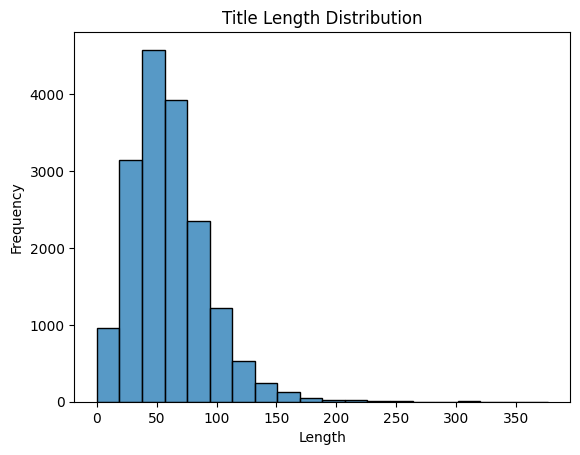

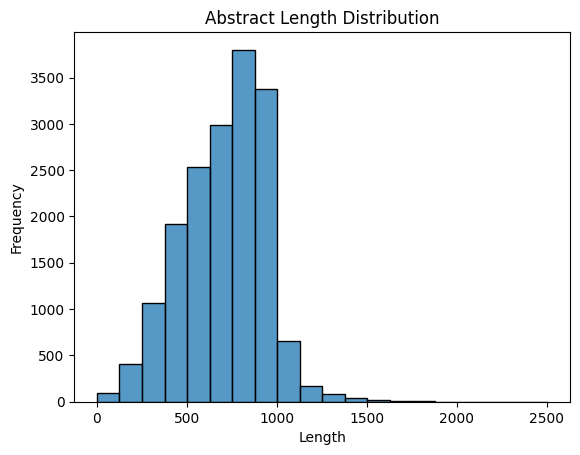

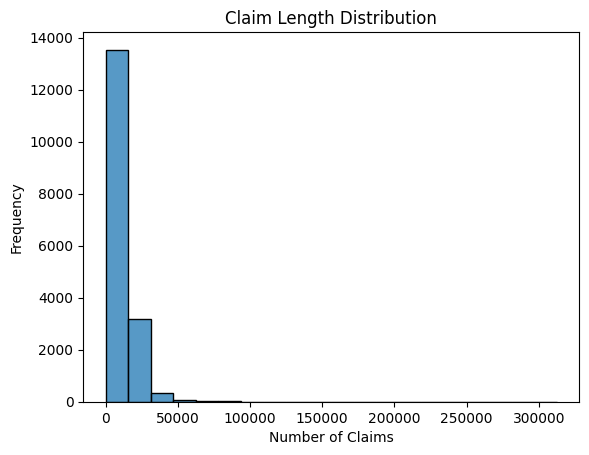

In [ ]:
# Distribution of IPC sections
print("\nTop IPC Sections:")
print(df['section'].value_counts().head(10))

# Distribution of invention titles' lengths
df['title_length'] = df['invention_title'].fillna('').apply(len)
df['abstract_length'] = df['abstract'].fillna('').apply(len)
df['claims_length'] = df['claims'].apply(len)

# Histograms
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['title_length'], bins=20)
plt.title("Title Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df['abstract_length'], bins=20)
plt.title("Abstract Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df['claims_length'], bins=20)
plt.title("Claim Length Distribution")
plt.xlabel("Number of Claims")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Preview a few of the shortest claim_1 values
main_directory = "/content/drive/My Drive/266_NLP/final project/"
df=pd.read_csv(main_directory + "uspto_patents_cpc_metadata.csv")

print("\nShortest combined_text examples:")
shortest_claims = df.copy()
shortest_claims["combined_text_length"] = shortest_claims["combined_text"].str.len()
shortest_claims = shortest_claims.sort_values("combined_text_length").head(10)
print(shortest_claims[["publication_number", "combined_text_length", "combined_text"]])



Shortest combined_text examples:
      publication_number  combined_text_length                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          combined_text
6506            D1079878                    72                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
import os
import shutil
import pandas as pd

# Load the DataFrame
# df = pd.read_csv(output_csv)
main_directory = "/content/drive/My Drive/266_NLP/final project/"
df=pd.read_csv(main_directory + "uspto_patents_cpc_metadata.csv")
destination_folder = "/content/drive/My Drive/266_NLP/final project/test_patents"
directory = "/content/drive/My Drive/266_NLP/final project/uspto_patents/"

# Display full column width and full DataFrame without truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Compute combined text length
df["combined_text_length"] = df["combined_text"].str.len()

# Filter rows with short combined text
short_combined = df[df["combined_text_length"] <= 200]

# Print summary and preview
print(f"\nNumber of patents with abstract length ≤ 200: {len(short_combined)}")
print(short_combined.head(10))

# # Copy files
# for _, row in short_combined.iterrows():
#     source_path = directory + row["file"]  # Replace with actual column name if different
#     if os.path.exists(source_path):
#         shutil.copy(source_path, destination_folder)
#         print ("copied")
#     else:
#         print(f"File not found: {source_path}")



Number of patents with abstract length ≤ 200: 5
               file publication_number  application_number  publication_date  application_date                                                         invention_title section           class          subclass                      main_group                                                                   subgroup country                        assignee inventor_1 abstract                                                                                                                      claims                                                                                                                                                                                       combined_text  combined_text_length
3491  doc_10407.xml           D1079447            29918634          20250617          20231129                                          Circular angled gate carabiner     A,F  ['A44', 'F16']  ['A44B', 'F16B']            ['A44B15', 'F

In [ ]:
print(f"Copying to: {os.path.abspath(destination_folder)}")


Copying to: /content/drive/My Drive/266_NLP/final project/uspto_patents/test_patents


In [ ]:
import shutil
import os

# Define source and destination paths
source_file = main_directory + 'uspto_patents/doc_11108.xml'
destination_folder = main_directory
destination_file = os.path.join(destination_folder, source_file)

# Create destination directory if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy the file
shutil.copy(source_file, destination_file)

print(f"Copied {source_file} to {destination_folder}")


In [ ]:
# Drop rows with publication_number starting with 'D'
df = df[~df["publication_number"].str.startswith("D")]
df

,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,abstract,assignee,inventor_1,inventor_2,claims,claim_1,combined_text,combined_text_length
0,doc_17456.xml,12335277,17656250,20250617,20220324,Frame invalidation in the bus system including...,H,['H04'],['H04L'],"['H04L12', 'H04L2012', 'H04L63']","['H04L12-40013', 'H04L12-40019', 'H04L2012-402...",US,"A node device for a bus system, including a tr...",ROBERT BOSCH GMBH,Kneib,Schell,"1. A node device for a bus system, comprising:...","1. A node device for a bus system, comprising:...",frame invalidation in the bus system including...,8692
1,doc_16086.xml,12333894,18123626,20250617,20230320,Game management system to track game play by p...,G,['G07'],['G07F'],['G07F17'],"['G07F17-3206', 'G07F17-322', 'G07F17-3225', '...",US,A game management system that manages a casino...,"ANGEL GROUP CO., LTD.",Shigeta,NaN,1. A game management system for management of ...,1. A game management system for management of ...,game management system to track game play by p...,6714
2,doc_17388.xml,12335209,18382712,20250617,20231023,Method and system of obtaining contact informa...,"G,H","['G06', 'H04']","['G06F', 'G06Q', 'G06V', 'H04L']","['G06F40', 'G06Q10', 'G06V30', 'H04L51', 'H04L...","['G06F40-295', 'G06Q10-107', 'G06V30-224', 'H0...",US,A method of obtaining contact information for ...,"INTERDIGITAL CE PATENT HOLDINGS, SAS",Carr,NaN,1. A method comprising: providing an indicatio...,1. A method comprising: providing an indicatio...,method and system of obtaining contact informa...,2139
3,doc_17155.xml,12334975,18110206,20250617,20230215,System for in-band spectral cross-talk monitoring,H,['H04'],['H04B'],['H04B10'],"['H04B10-0731', 'H04B10-801']",US,Systems and methods are described for in-band ...,"Mellanox Technologies, Ltd.",Seyedi,NaN,1. A system for in-band spectral cross-talk mo...,1. A system for in-band spectral cross-talk mo...,system for in-band spectral cross-talk monitor...,6533
4,doc_18568.xml,12336404,18645555,20250617,20240425,Display panel and display device including blo...,"G,H","['G06', 'G09', 'H10']","['G06F', 'G09G', 'H10K']","['G06F3', 'G09G2300', 'G09G2320', 'G09G2330', ...","['G06F3-00', 'G06F3-033', 'G09G2300-0426', 'G0...",US,Disclosed are a display panel and a display de...,"BOE TECHNOLOGY GROUP CO., LTD.",Wang,Han,"1. A display panel, comprising: a base substra...","1. A display panel, comprising: a base substra...",display panel and display device including blo...,7842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15947,doc_3490.xml,20250197752,18978387,20250619,20241212,PROCESS AND/OR FACILITY INTEGRATION OF ANAEROB...,"B,C","['B01', 'C10', 'C12']","['B01D', 'C10L', 'C12F']","['B01D1', 'B01D3', 'C10L2290', 'C10L3', 'C12F3']","['B01D1-26', 'B01D3-001', 'B01D3-40', 'C10L229...",US,A bioprocessing facility that includes an anae...,NaN,Carlson,Wood,a source of one or more stillage compositions;...,a source of one or more stillage compositions;...,process and/or facility integration of anaerob...,6725
15948,doc_4350.xml,20250198512,18979589,20250619,20241212,PISTON RING ASSEMBLY,F,['F16'],['F16J'],['F16J9'],['F16J9-18'],US,A piston ring assembly is disclosed. The pisto...,NaN,Moreira,NaN,an annular basic body having a gap; a cover el...,an annular basic body having a gap; a cover el...,piston ring assembly a piston ring assembly is...,4663
15949,doc_2748.xml,20250197094,19072181,20250619,20250306,DISPENSING PACKAGE FOR SHEET MATERIAL,"A,B","['A47', 'B65']","['A47K', 'B65D']","['A47K10', 'A47K2010', 'B65D2583', 'B65D5', 'B...","['A47K10-42', 'A47K2010-3233', 'B65D2583-082',...",US,A hangable and expandable prism-shaped dispens...,NaN,Shihor,NaN,a base wall; a top wall having a rear edge and...,a base wall; a top wall having a rear edge and...,dispensing package for sheet material a hangab...,1681
15950,doc_1731.xml,20250196077,18845689,2025061

In [ ]:
df.to_csv(output_csv, index=False)